# Question 1: When is the best time of day, day of the week, and time of year to fly to minimize delays?

Before analyzing and visualizing the best time of the day, day of the week, and time of the year to fly to minimize delays, data has been pre-processed to ensure that correct data is extracted for analysis regarding on question 1. 

## Data pre-processing
### Load the library


In [1]:
import sqlite3
import pandas as pd
import os
import numpy as np
from datetime import datetime
import networkx as nx
import calendar
import seaborn as sns 
import matplotlib.pyplot as plt
import random

### Creating Database from SQLite3

Due to large data set provided by the Harvard Dataverse at: https://doi.org/10.7910/DVN/HG7NV7 , SQLite3 database is used to facilitate efficient performance by offloading resources used in computer and dedicate it into SQLite3 database sever, making it easier to load, extract and save the data whenever query.





#### Removes existing files and write a clean slate ( if fails to remove, the process it will continue).

In [2]:
# Set current working directory.
os.chdir('D:/SIM courses/Programming/Project/Project/project_py')

try: 
    os.remove('airline.db') 
except OSError: 
    pass

Connects directly to SQLite3 database and write record stored in DataFrames as tables to database airline.db using `.to_sql()`.

In [3]:
conn = sqlite3.connect('D:/SIM courses/Programming/Project/Project/project_py/airline.db')

airports = pd.read_csv("D:/SIM courses/Programming/Project/airports.csv")
carriers = pd.read_csv("D:/SIM courses/Programming/Project/carriers.csv")
planes = pd.read_csv("D:/SIM courses/Programming/Project/plane-data.csv")

airports.to_sql('airports', con = conn, index = False)
carriers.to_sql('carriers', con = conn, index = False)
planes.to_sql('planes', con = conn, index = False)
c = conn.cursor () # connecting to cursor object, cursor =  instance through invoking methods that execute SQLite statements.
c.execute("SELECT name FROM sqlite_master where type = 'table'").fetchall() 



[('airports',), ('carriers',), ('planes',)]

Creating the table first helps to avoid the warning message about mixed data type in a big database.

In [4]:
c.execute('''
CREATE TABLE ontime (
    Year int,
    Month int,
    DayofMonth int,
    DayofWeek int,
    DepTime int,
    CRSDepTime int,
    ArrTime int,
    CRSArrTime int,
    UniqueCarrier varchar(5),
    FlightNum int,
    TailNum varchar(8),
    ActualElapsedTime int,
    CRSElapsedTime int,
    AirTime int, 
    ArrDelay int, 
    DepDelay int,
    Origin varchar(3),
    Dest varchar(3),
    Distance int,
    TaxiIn int,
    TaxiOut int,
    Cancelled int,
    CancellationCode varchar(1),
    Diverted varchar(1),
    CarrierDelay int,
    WeatherDelay int,
    NASDelay int,
    SecurityDelay int,
    LateAircraftDelay int
)
''')
conn.commit() # confirm changes, similar to "write changes".


Due to limitation on computer system, 2 years of data set (2007-2008) has been randomly subset into 30% and appended accordingly into the database created from above. Note: analysis may be different due to random subset sampled data.

In [5]:
p = 0.3

for year in range (2007, 2009):
    filename = "D:/SIM courses/Programming/Project/"+str(year)+".csv"  # strings of file names from various years 2006:2007.
    print('Processing:', year)
    ontime = pd.read_csv(filename, header=0, dtype={'Cancelled': int}, skiprows= lambda i: i>0 and random.random() >p) # forces this to a specific data type to avoid warning messages.
    ontime.to_sql('ontime', con = conn, if_exists = 'append', index = False)

conn.commit()# confirm changes

Processing: 2007
Processing: 2008


Check for missing values or rows and remove accordingly to avoid any programming errors during query.

In [6]:
airports[airports.isnull().any(axis=1)]
carriers[carriers.isnull().any(axis=1)]
ontime[ontime.isnull().any(axis=1)]
planes[planes.isnull().any(axis=1)]

planes = planes.dropna(axis=0)
carriers = carriers.dropna(axis=0)
ontime = ontime.dropna(axis=0, how='all')
conn.commit()# confirm changes

#### For running existing database file:


In [7]:
conn = sqlite3.connect('D:/SIM courses/Programming/Project/Project/project_py/airline.db')
c = conn.cursor() 
c.execute("SELECT name FROM sqlite_master where type = 'table'").fetchall() 

[('airports',), ('carriers',), ('planes',), ('ontime',)]

### Data cleaning
Assumption made on the criteria for outliers on departure and arrival delay to be removed if it exceeds 240 minutes (4hours) based on airline policies and thus, will be updated into the database.

In [8]:
c.execute(
    ''' 
    DELETE FROM ontime
    WHERE DepDelay >240 OR ArrDelay >240
    ''').fetchall()
conn.commit() 


df = pd.read_sql_query(
    '''
    SELECT *
    FROM ontime
    ''', conn)
    
df['DepDelay']
(df[['DepDelay',"ArrDelay"]]>240).any(axis=0).sum() 

0


### Data Query
#### Question 1: When is the best time of day, day of the week, and time of year to fly to minimize delays?
Data has been retrieved from SQLite3 database and grouped its departure time into morning, afternoon and evening, day of week into respective name of weekdays and weekend and quarterly for over range of months, and calculate its average departure delay for non-cancelled flights.

In [9]:
q1 = c.execute('''   
                SELECT AVG(DepDelay) as avg_depdelay, DepTime, Month, DayOfWeek
                FROM ontime
                WHERE Cancelled = 0 
                GROUP BY DepTime, Month, DayOfWeek
                ORDER BY avg_depdelay ASC
                  ''').fetchall()
q1 = pd.DataFrame(q1).reset_index() # reset index used for renaming colnames
q1.columns = ['index', 'avg_depdelay', 'deptime', 'month', 'dayofweek']

q1 = q1.drop(columns=['index'])
q1['quarterly'] = np.digitize(q1['month'], [3, 6, 9, 12], right=True) + 1
q1['nameofmonth'] = q1['month'].apply(lambda x: calendar.month_name[x])

q1['period_time'] = ['Morning' if 500<=x<1200 else 'Afternoon' if 1200<=x<1700 else 'Evening' if 1700<=x<2100 else 'Night' for x in q1['deptime']]
q1

q1['nameofday']=""
q1.loc[(q1['dayofweek'] == 1), "nameofday"] = 'Monday'
q1.loc[(q1['dayofweek'] == 2), "nameofday"] = 'Tuesday'
q1.loc[(q1['dayofweek'] == 3), "nameofday"] = 'Wednesday'
q1.loc[(q1['dayofweek'] == 4), "nameofday"] = 'Thursday'
q1.loc[(q1['dayofweek'] == 5), "nameofday"] = 'Friday'
q1.loc[(q1['dayofweek'] == 6), "nameofday"] = 'Saturday'
q1.loc[(q1['dayofweek'] == 7), "nameofday"] = 'Sunday'

q1 = q1.drop(columns=['month','dayofweek','deptime'])
q2 = q1.groupby(['period_time', 'nameofday', 'quarterly']).mean().reset_index() #,'nameofmonth'

q2['period_time'] = q2['period_time'].astype('category')
q2['period_time'] = pd.Categorical(q2['period_time'], categories=['Morning','Afternoon','Evening','Night'])
q2['period_time'].dtype

q2['nameofday'] = q2['nameofday'].astype('category')
q2['nameofday'] = pd.Categorical(q2['nameofday'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])
q2['nameofday'].dtype


CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                  'Saturday', 'Sunday'],
, ordered=False)

Plot heatmap to show the time, day and period of the year to minimize flight departure delays.

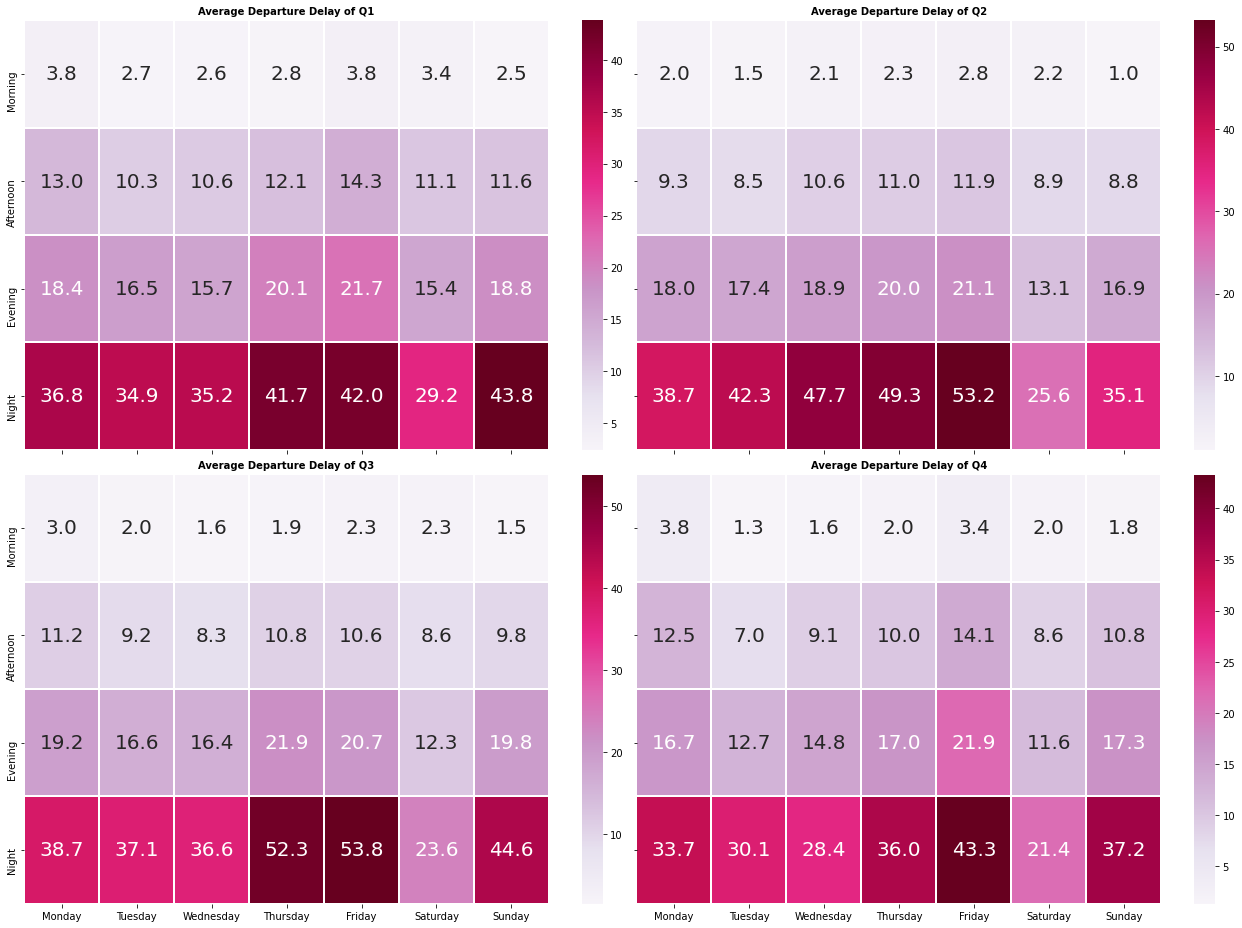

In [10]:
data = q2    
q2.isnull().sum()

def facet_heatmap(data, color, **kws):
    data = data.pivot(index="period_time", columns='nameofday', values='avg_depdelay')
    sns.heatmap(data, cmap='PuRd',annot=True, annot_kws={"size": 20},fmt=".1f",linewidth=1, **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(data, col="quarterly", col_wrap=2, height=10, aspect=1)
    g.fig.set_size_inches(20,13)

g = g.map_dataframe(facet_heatmap) 

g.set_titles(col_template="Average Departure Delay of Q{col_name}", fontweight='bold', fontsize=30)
g.fig.subplots_adjust(right=.9)

In [11]:
conn.close()